In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Construct a Simple Example

Create a simple periodic time series data.

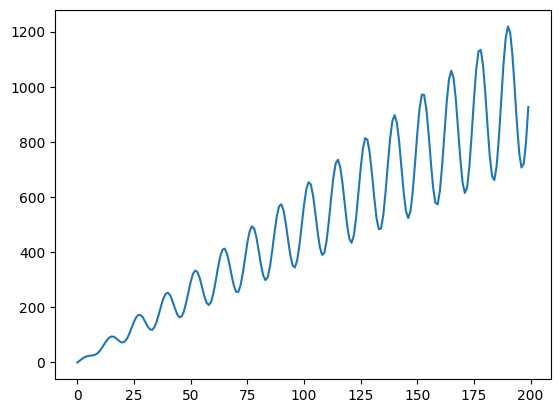

In [2]:
t = list(range(0, 200))

timeseries = []
for x in t:
    res = x * np.sin(x/2) + x * np.cos(x/2) + 5*x
    timeseries.append(res)

timeseries = np.array(timeseries)
plt.plot(t, timeseries);

# 2. Format the Data and Inject Anomalies

Format the data into a `pandas` dataframe, consisting of two columns: `timestamp` and `values`.

In addition, we create a simple synthetic anomaly by altering the normal pattern of the signal.

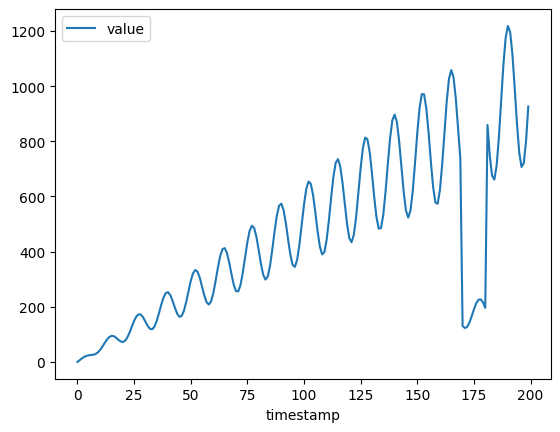

In [3]:
df = pd.DataFrame({
    'timestamp': t,
    'value': timeseries
})

# inject synthetic anomaly arbitrarly
df.loc[170:180, 'value'] /= 5

df.plot(x='timestamp', y='value');

# 3. Using SigLLM for Anomaly Detection

We will be using `mistral_detector` pipeline to find anomalies in the time series data we just created.

First, we load the pipeline we want to use, and define the hyperparameters we want to set for the pipeline. In this case, we would like to alter:
* `interval` which is the time between one `timestamp` and another, here it is `1`.
* `decimal` our data is in the range [0-1200] making it unnecessary to keep decimal values. Therefore, we use `0`.
* `anomaly_padding` how many time points around the detected index to include as anomalous. We keep it very small, set to `2` time points.

In [4]:
from sigllm import SigLLM

pipeline_name = 'mistral_detector'

hyperparameters = {
    "orion.primitives.timeseries_anomalies.find_anomalies#1": {
        "anomaly_padding": 2
    }
}

sigllm = SigLLM(
    pipeline_name,
    interval=1,
    decimal=0,
    hyperparameters=hyperparameters
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

we first learn the parameters of some of the primitives in the model, such as `SimpleImpute`, by using the `fit` function. Note that because we are using pretrained models, we actually don't perform any training.

In [5]:
sigllm.fit(df)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/smish/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/impute/_base.py:356: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


next, we use the `detect` function to find anomalies. This step takes some time to finish since we are probing the LLM to forecast a signal for multiple windows.

In [6]:
anomalies = sigllm.detect(df)

/home/smish/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/impute/_base.py:356: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
  0%|          | 0/60 [00:00<?, ?it/s]2024-09-13 15:41:10.047941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 15:41:10.047978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 15:41:10.048004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 15:41:10.054011: I t

In [7]:
anomalies

,start,end,severity
0,168,172,0.005654


we can see that the anomaly was detected at timestamp `170` and since we set `anomaly_padding=2` we include two time points before and after the detection time.

---